In [8]:
import torch
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import subprocess

print("=" * 80)
print("NUTRIGREEN MODEL EVALUATION (SIMPLE VERSION)")
print("=" * 80)

NUTRIGREEN MODEL EVALUATION (SIMPLE VERSION)


In [9]:
# ============================================================================
# 1. SETUP
# ============================================================================
print("\n" + "=" * 80)
print("SETUP")
print("=" * 80)

BASE_DIR = Path(r"C:\Users\lokes\Desktop\ironhack\final_project\dataset\dataset")
YOLO_DIR = BASE_DIR / "yolov5_data"
YOLO_REPO = BASE_DIR / "yolov5"
RUNS_DIR = BASE_DIR / "runs"
EXP_DIR = RUNS_DIR / "nutrigreen_exp"
WEIGHTS_PATH = EXP_DIR / "weights" / "best.pt"
CONFIG_FILE = YOLO_DIR / "nutrigreen.yaml"

print(f"Base directory: {BASE_DIR}")
print(f"YOLOv5 repo: {YOLO_REPO}")
print(f"Model weights: {WEIGHTS_PATH}")
print(f"Dataset config: {CONFIG_FILE}")

# Check device with better error handling
device = 'cpu'  # Default to CPU

print("\nChecking GPU availability...")
try:
    if torch.cuda.is_available():
        gpu_count = torch.cuda.device_count()
        print(f"✓ CUDA is available")
        print(f"  Number of GPUs: {gpu_count}")
        
        if gpu_count > 0:
            try:
                gpu_name = torch.cuda.get_device_name(0)
                print(f"  GPU 0: {gpu_name}")
                device = '0'
                print(f"\n✓ Using GPU 0")
            except Exception as e:
                print(f"⚠ GPU detected but cannot access: {e}")
                print(f"  Falling back to CPU")
                device = 'cpu'
        else:
            print("⚠ CUDA available but no GPU devices found")
            device = 'cpu'
    else:
        print("⚠ CUDA not available - using CPU (slower)")
        device = 'cpu'
except Exception as e:
    print(f"⚠ Error checking GPU: {e}")
    print("  Using CPU as fallback")
    device = 'cpu'

print(f"\nDevice for validation: {device}")

# Verify files exist
if not WEIGHTS_PATH.exists():
    print(f"\n❌ ERROR: Model weights not found at {WEIGHTS_PATH}")
    print("Please run the training notebook first!")
    sys.exit(1)

if not YOLO_REPO.exists():
    print(f"\n❌ ERROR: YOLOv5 repository not found at {YOLO_REPO}")
    print("Training should have created this. Please run training notebook.")
    sys.exit(1)

print("\n✓ All required files found")

# Class names
class_names = ['NutriScore A', 'NutriScore B', 'NutriScore C', 
               'NutriScore D', 'NutriScore E', 'BIO', 'V-Label']



SETUP
Base directory: C:\Users\lokes\Desktop\ironhack\final_project\dataset\dataset
YOLOv5 repo: C:\Users\lokes\Desktop\ironhack\final_project\dataset\dataset\yolov5
Model weights: C:\Users\lokes\Desktop\ironhack\final_project\dataset\dataset\runs\nutrigreen_exp\weights\best.pt
Dataset config: C:\Users\lokes\Desktop\ironhack\final_project\dataset\dataset\yolov5_data\nutrigreen.yaml

Checking GPU availability...
✓ CUDA is available
  Number of GPUs: 1
  GPU 0: NVIDIA GeForce RTX 3060 Laptop GPU

✓ Using GPU 0

Device for validation: 0

✓ All required files found


In [10]:
# ============================================================================
# 2. RUN VALIDATION ON TEST SET
# ============================================================================
print("\n" + "=" * 80)
print("RUNNING VALIDATION ON TEST SET")
print("=" * 80)

import os
os.chdir(YOLO_REPO)

# Create validation output directory
VAL_DIR = RUNS_DIR / 'nutrigreen_val'
VAL_DIR.mkdir(parents=True, exist_ok=True)

val_cmd = [
    sys.executable,
    'val.py',
    '--weights', str(WEIGHTS_PATH),
    '--data', str(CONFIG_FILE),
    '--img', '640',
    '--batch-size', '16',
    '--device', device,
    '--project', str(RUNS_DIR),
    '--name', 'nutrigreen_val',
    '--exist-ok',
    '--save-txt',
    '--save-conf',
    '--save-json',
    '--task', 'test',  # Use test set
    '--verbose'
]

print("\nValidation command:")
print(' '.join(val_cmd))
print("\nRunning validation (this may take a few minutes)...")
print("-" * 80)

try:
    result = subprocess.run(val_cmd, check=True, 
                          capture_output=False,  # Show output in real-time
                          text=True)
    print("\n" + "-" * 80)
    print("✓ Validation completed successfully!")
    
except subprocess.CalledProcessError as e:
    print(f"\n❌ Validation failed with error code: {e.returncode}")
    print("Check the output above for error details")
    # Don't exit - we can still analyze partial results



RUNNING VALIDATION ON TEST SET

Validation command:
c:\anaconda\envs\ironhack\python.exe val.py --weights C:\Users\lokes\Desktop\ironhack\final_project\dataset\dataset\runs\nutrigreen_exp\weights\best.pt --data C:\Users\lokes\Desktop\ironhack\final_project\dataset\dataset\yolov5_data\nutrigreen.yaml --img 640 --batch-size 16 --device 0 --project C:\Users\lokes\Desktop\ironhack\final_project\dataset\dataset\runs --name nutrigreen_val --exist-ok --save-txt --save-conf --save-json --task test --verbose

Running validation (this may take a few minutes)...
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
✓ Validation completed successfully!


In [11]:
# ============================================================================
# 3. ANALYZE VALIDATION RESULTS
# ============================================================================
print("\n" + "=" * 80)
print("ANALYZING VALIDATION RESULTS")
print("=" * 80)

# Check what files were created
print("\nGenerated files:")
val_files = list(VAL_DIR.glob('*.*'))
for f in val_files[:10]:  # Show first 10 files
    print(f"  {f.name}")
if len(val_files) > 10:
    print(f"  ... and {len(val_files) - 10} more files")

# Read and display metrics from results.csv if available
results_csv = VAL_DIR / 'results.csv'
if results_csv.exists():
    print(f"\n✓ Found results CSV: {results_csv.name}")
    
    results_df = pd.read_csv(results_csv)
    results_df.columns = results_df.columns.str.strip()
    
    print("\n" + "=" * 80)
    print("TEST SET METRICS (from validation)")
    print("=" * 80)
    
    # Display key metrics
    metrics_to_show = {
        'Precision': 'metrics/precision',
        'Recall': 'metrics/recall',
        'mAP@0.5': 'metrics/mAP_0.5',
        'mAP@0.5:0.95': 'metrics/mAP_0.5:0.95',
        'Box Loss': 'val/box_loss',
        'Obj Loss': 'val/obj_loss',
        'Cls Loss': 'val/cls_loss'
    }
    
    print("\nTest Set Performance:")
    for metric_name, col_name in metrics_to_show.items():
        if col_name in results_df.columns:
            value = results_df[col_name].iloc[0]
            print(f"  {metric_name:<20}: {value:.4f}")
        else:
            print(f"  {metric_name:<20}: Not available")
    
    # Create metrics summary table
    metrics_summary = pd.DataFrame({
        'Metric': list(metrics_to_show.keys()),
        'Value': [results_df[col].iloc[0] if col in results_df.columns else 0 
                 for col in metrics_to_show.values()]
    })
    
    # Plot metrics bar chart
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Separate into performance metrics and loss metrics
    perf_metrics = metrics_summary.iloc[:4]
    loss_metrics = metrics_summary.iloc[4:]
    
    # Plot performance metrics
    bars1 = ax.bar(range(len(perf_metrics)), perf_metrics['Value'], 
                   color=['#2ecc71', '#3498db', '#e74c3c', '#f39c12'])
    ax.set_xticks(range(len(perf_metrics)))
    ax.set_xticklabels(perf_metrics['Metric'], rotation=45, ha='right')
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('Test Set Performance Metrics', fontsize=14, fontweight='bold')
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars1, perf_metrics['Value'])):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{val:.3f}',
               ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(VAL_DIR / 'test_metrics_summary.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"\n✓ Test metrics plot saved to: {VAL_DIR / 'test_metrics_summary.png'}")

else:
    # Try to read from text output
    results_files = list(VAL_DIR.glob('results*.txt'))
    if results_files:
        print(f"\n✓ Found results file: {results_files[0].name}")
        with open(results_files[0], 'r') as f:
            print("\nTest Set Validation Results:")
            print(f.read())


ANALYZING VALIDATION RESULTS

Generated files:
  all_curves.png
  all_metrics_summary.csv
  best_predictions.json
  complete_evaluation_summary.txt
  complete_training_history.png
  confusion_matrix.png
  confusion_matrix_displayed.png
  evaluation_summary.txt
  F1_curve.png
  performance_curves.png
  ... and 9 more files



TRAINING AND VALIDATION HISTORY
✓ Found training history: C:\Users\lokes\Desktop\ironhack\final_project\dataset\dataset\runs\nutrigreen_exp\results.csv

Training completed for 25 epochs

--------------------------------------------------------------------------------
FINAL TRAINING METRICS (Last Epoch)
--------------------------------------------------------------------------------

Last Epoch Metrics:
  Train Box Loss           : 0.0146
  Train Obj Loss           : 0.0053
  Train Cls Loss           : 0.0034
  Val Box Loss             : 0.0104
  Val Obj Loss             : 0.0043
  Val Cls Loss             : 0.0016
  Precision                : 0.9923
  Recall                   : 0.9810
  mAP@0.5                  : 0.9924
  mAP@0.5:0.95             : 0.8858

--------------------------------------------------------------------------------
BEST METRICS DURING TRAINING
--------------------------------------------------------------------------------

Best Values Achieved:
  Best mAP@0.5    

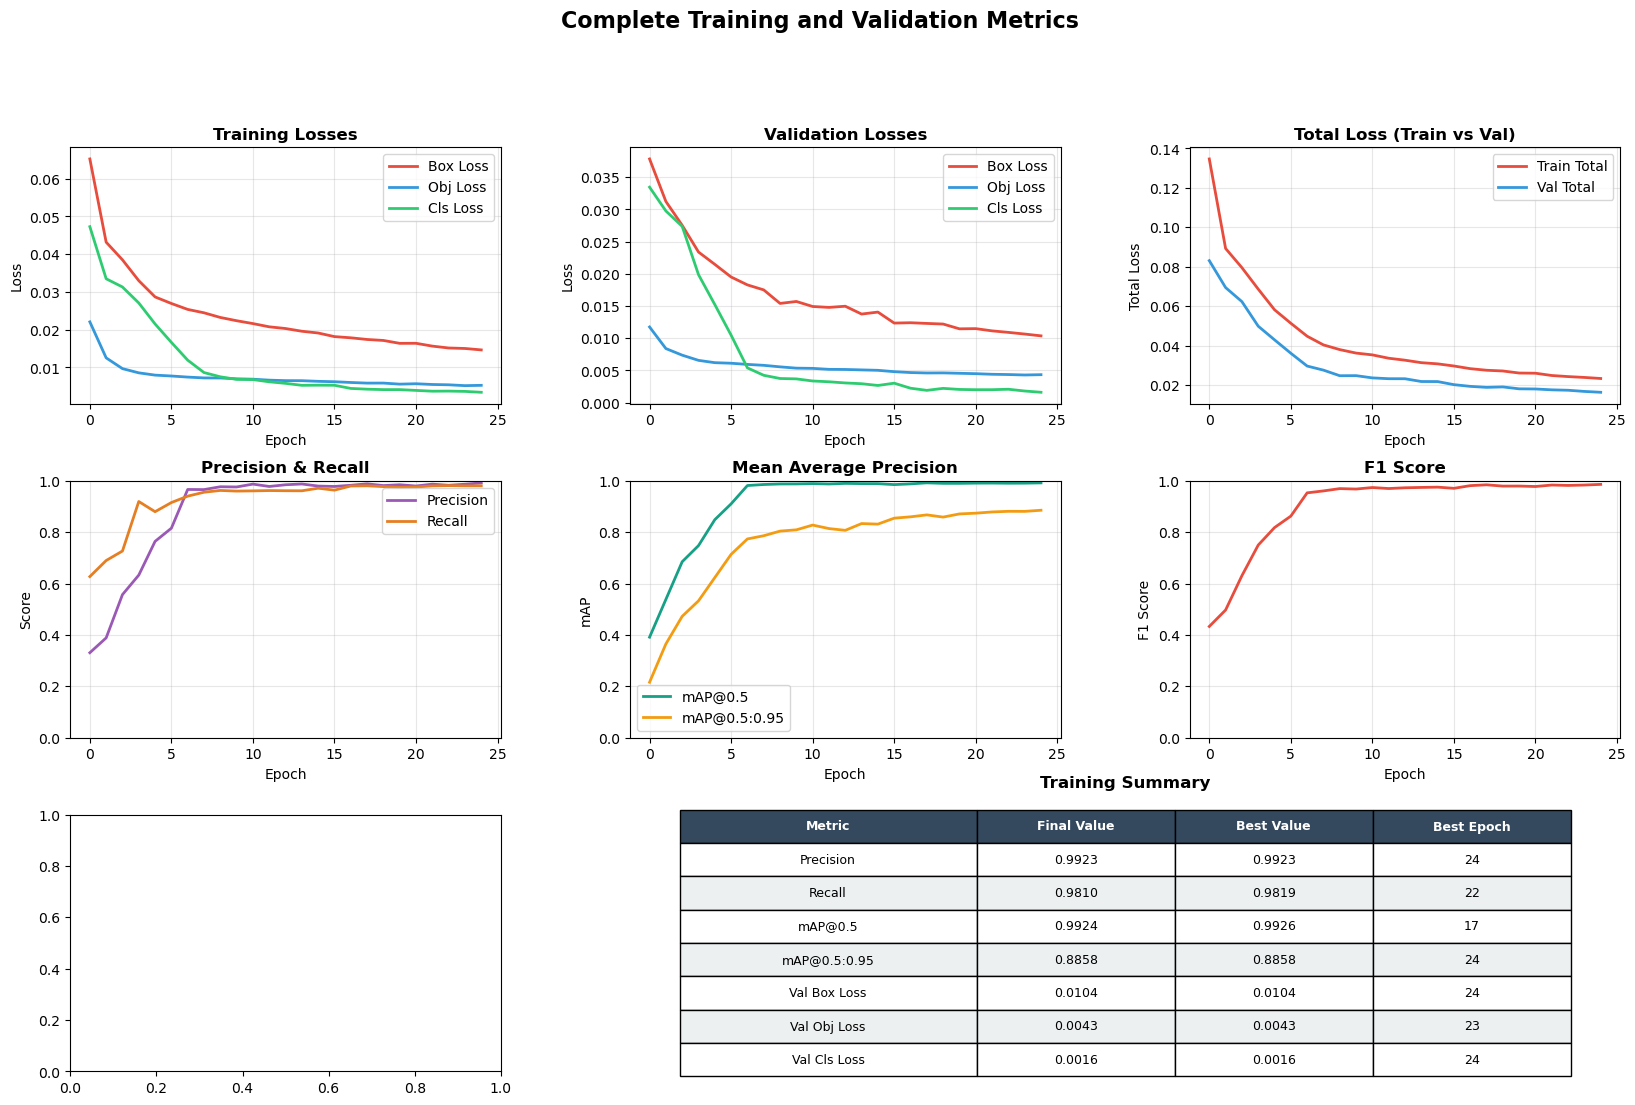

✓ All metrics exported to: C:\Users\lokes\Desktop\ironhack\final_project\dataset\dataset\runs\nutrigreen_val\all_metrics_summary.csv

COMPLETE METRICS COMPARISON

        Set  Box_Loss  Obj_Loss  Cls_Loss  Precision  Recall  mAP_0.5  mAP_0.5_0.95
  Training  0.014644  0.005254  0.003415    0.99228 0.98101   0.9924       0.88583
Validation  0.010372  0.004342  0.001608    0.99228 0.98101   0.9924       0.88583
      Test  0.000000  0.000000  0.000000    0.00000 0.00000   0.0000       0.00000

CONFUSION MATRIX
✓ Confusion matrix: C:\Users\lokes\Desktop\ironhack\final_project\dataset\dataset\runs\nutrigreen_val\confusion_matrix.png


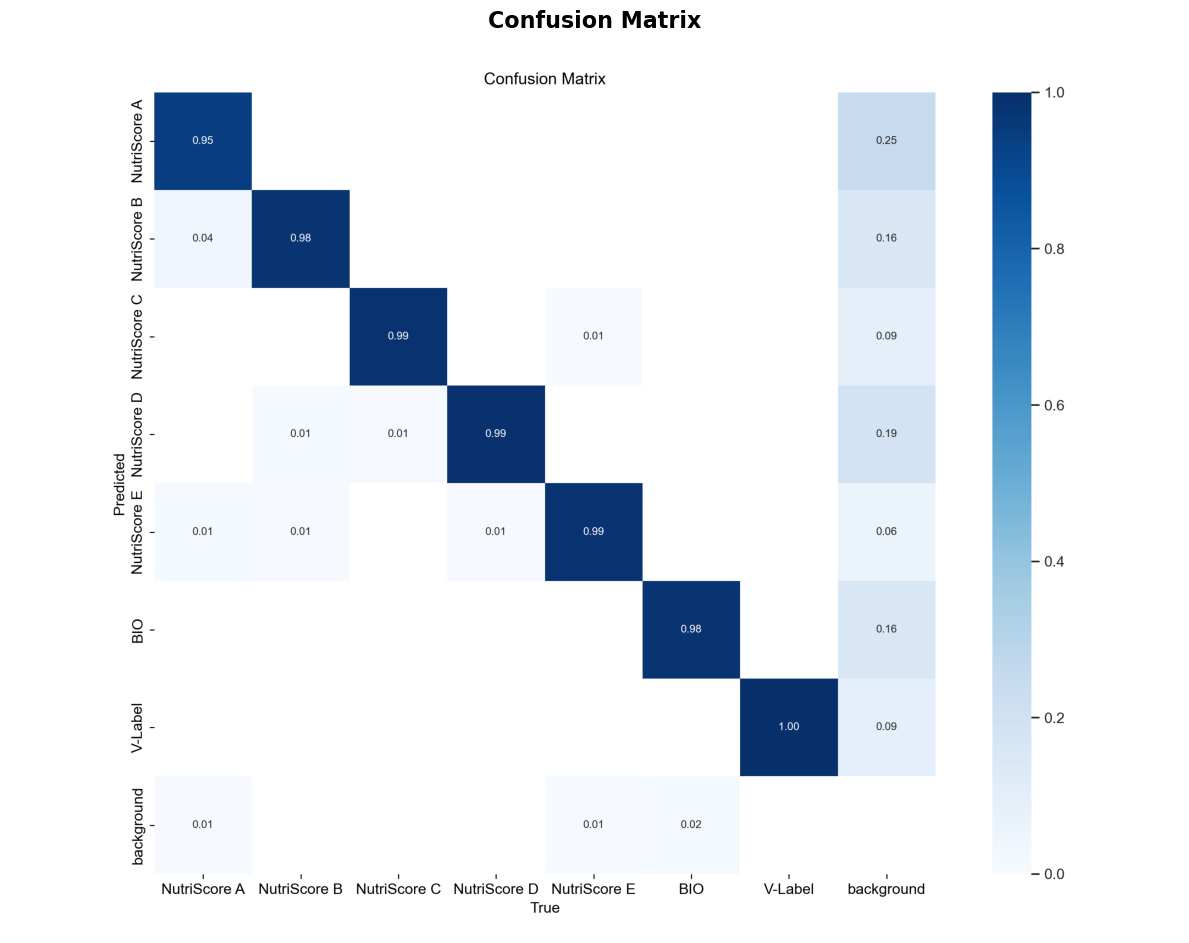

✓ Confusion matrix displayed


In [12]:
# ============================================================================
# 4. LOAD AND ANALYZE TRAINING HISTORY
# ============================================================================
print("\n" + "=" * 80)
print("TRAINING AND VALIDATION HISTORY")
print("=" * 80)

# Load training results
train_results_path = EXP_DIR / 'results.csv'

if train_results_path.exists():
    print(f"✓ Found training history: {train_results_path}")
    
    train_df = pd.read_csv(train_results_path)
    train_df.columns = train_df.columns.str.strip()
    
    # Add epoch column if not present
    if 'epoch' not in train_df.columns:
        train_df.insert(0, 'epoch', range(len(train_df)))
    
    print(f"\nTraining completed for {len(train_df)} epochs")
    
    # Display final metrics
    print("\n" + "-" * 80)
    print("FINAL TRAINING METRICS (Last Epoch)")
    print("-" * 80)
    
    final_metrics = {
        'Train Box Loss': 'train/box_loss',
        'Train Obj Loss': 'train/obj_loss',
        'Train Cls Loss': 'train/cls_loss',
        'Val Box Loss': 'val/box_loss',
        'Val Obj Loss': 'val/obj_loss', 
        'Val Cls Loss': 'val/cls_loss',
        'Precision': 'metrics/precision',
        'Recall': 'metrics/recall',
        'mAP@0.5': 'metrics/mAP_0.5',
        'mAP@0.5:0.95': 'metrics/mAP_0.5:0.95'
    }
    
    print("\nLast Epoch Metrics:")
    for metric_name, col_name in final_metrics.items():
        if col_name in train_df.columns:
            value = train_df[col_name].iloc[-1]
            print(f"  {metric_name:<25}: {value:.4f}")
    
    # Display best metrics
    print("\n" + "-" * 80)
    print("BEST METRICS DURING TRAINING")
    print("-" * 80)
    
    best_metrics = {
        'Best mAP@0.5': ('metrics/mAP_0.5', 'max'),
        'Best mAP@0.5:0.95': ('metrics/mAP_0.5:0.95', 'max'),
        'Best Precision': ('metrics/precision', 'max'),
        'Best Recall': ('metrics/recall', 'max'),
        'Lowest Val Box Loss': ('val/box_loss', 'min'),
        'Lowest Val Obj Loss': ('val/obj_loss', 'min'),
        'Lowest Val Cls Loss': ('val/cls_loss', 'min')
    }
    
    print("\nBest Values Achieved:")
    for metric_name, (col_name, agg) in best_metrics.items():
        if col_name in train_df.columns:
            if agg == 'max':
                value = train_df[col_name].max()
                epoch = train_df[col_name].idxmax()
            else:
                value = train_df[col_name].min()
                epoch = train_df[col_name].idxmin()
            print(f"  {metric_name:<25}: {value:.4f} (Epoch {epoch})")
    
    # Create comprehensive training plots
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # Plot 1: Training Losses
    ax1 = fig.add_subplot(gs[0, 0])
    if 'train/box_loss' in train_df.columns:
        ax1.plot(train_df['epoch'], train_df['train/box_loss'], 
                label='Box Loss', linewidth=2, color='#e74c3c')
    if 'train/obj_loss' in train_df.columns:
        ax1.plot(train_df['epoch'], train_df['train/obj_loss'], 
                label='Obj Loss', linewidth=2, color='#3498db')
    if 'train/cls_loss' in train_df.columns:
        ax1.plot(train_df['epoch'], train_df['train/cls_loss'], 
                label='Cls Loss', linewidth=2, color='#2ecc71')
    ax1.set_xlabel('Epoch', fontsize=10)
    ax1.set_ylabel('Loss', fontsize=10)
    ax1.set_title('Training Losses', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Validation Losses
    ax2 = fig.add_subplot(gs[0, 1])
    if 'val/box_loss' in train_df.columns:
        ax2.plot(train_df['epoch'], train_df['val/box_loss'], 
                label='Box Loss', linewidth=2, color='#e74c3c')
    if 'val/obj_loss' in train_df.columns:
        ax2.plot(train_df['epoch'], train_df['val/obj_loss'], 
                label='Obj Loss', linewidth=2, color='#3498db')
    if 'val/cls_loss' in train_df.columns:
        ax2.plot(train_df['epoch'], train_df['val/cls_loss'], 
                label='Cls Loss', linewidth=2, color='#2ecc71')
    ax2.set_xlabel('Epoch', fontsize=10)
    ax2.set_ylabel('Loss', fontsize=10)
    ax2.set_title('Validation Losses', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Combined Losses
    ax3 = fig.add_subplot(gs[0, 2])
    if 'train/box_loss' in train_df.columns and 'val/box_loss' in train_df.columns:
        train_total = train_df[['train/box_loss', 'train/obj_loss', 'train/cls_loss']].sum(axis=1)
        val_total = train_df[['val/box_loss', 'val/obj_loss', 'val/cls_loss']].sum(axis=1)
        ax3.plot(train_df['epoch'], train_total, label='Train Total', linewidth=2, color='#e74c3c')
        ax3.plot(train_df['epoch'], val_total, label='Val Total', linewidth=2, color='#3498db')
    ax3.set_xlabel('Epoch', fontsize=10)
    ax3.set_ylabel('Total Loss', fontsize=10)
    ax3.set_title('Total Loss (Train vs Val)', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Precision and Recall
    ax4 = fig.add_subplot(gs[1, 0])
    if 'metrics/precision' in train_df.columns:
        ax4.plot(train_df['epoch'], train_df['metrics/precision'], 
                label='Precision', linewidth=2, color='#9b59b6')
    if 'metrics/recall' in train_df.columns:
        ax4.plot(train_df['epoch'], train_df['metrics/recall'], 
                label='Recall', linewidth=2, color='#e67e22')
    ax4.set_xlabel('Epoch', fontsize=10)
    ax4.set_ylabel('Score', fontsize=10)
    ax4.set_title('Precision & Recall', fontsize=12, fontweight='bold')
    ax4.set_ylim([0, 1])
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # Plot 5: mAP Metrics
    ax5 = fig.add_subplot(gs[1, 1])
    if 'metrics/mAP_0.5' in train_df.columns:
        ax5.plot(train_df['epoch'], train_df['metrics/mAP_0.5'], 
                label='mAP@0.5', linewidth=2, color='#16a085')
    if 'metrics/mAP_0.5:0.95' in train_df.columns:
        ax5.plot(train_df['epoch'], train_df['metrics/mAP_0.5:0.95'], 
                label='mAP@0.5:0.95', linewidth=2, color='#f39c12')
    ax5.set_xlabel('Epoch', fontsize=10)
    ax5.set_ylabel('mAP', fontsize=10)
    ax5.set_title('Mean Average Precision', fontsize=12, fontweight='bold')
    ax5.set_ylim([0, 1])
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # Plot 6: F1 Score (if available)
    ax6 = fig.add_subplot(gs[1, 2])
    # Calculate F1 score
    if 'metrics/precision' in train_df.columns and 'metrics/recall' in train_df.columns:
        precision = train_df['metrics/precision']
        recall = train_df['metrics/recall']
        f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
        ax6.plot(train_df['epoch'], f1, linewidth=2, color='#e74c3c')
        ax6.set_xlabel('Epoch', fontsize=10)
        ax6.set_ylabel('F1 Score', fontsize=10)
        ax6.set_title('F1 Score', fontsize=12, fontweight='bold')
        ax6.set_ylim([0, 1])
        ax6.grid(True, alpha=0.3)
    
    # Plot 7: Learning Rate (if available)
    ax7 = fig.add_subplot(gs[2, 0])
    lr_cols = [col for col in train_df.columns if 'lr/' in col.lower() or col == 'lr']
    if lr_cols:
        for lr_col in lr_cols:
            ax7.plot(train_df['epoch'], train_df[lr_col], 
                    label=lr_col.replace('lr/', ''), linewidth=2)
        ax7.set_xlabel('Epoch', fontsize=10)
        ax7.set_ylabel('Learning Rate', fontsize=10)
        ax7.set_title('Learning Rate Schedule', fontsize=12, fontweight='bold')
        ax7.legend()
        ax7.grid(True, alpha=0.3)
        ax7.set_yscale('log')
    
    # Plot 8: Metrics Summary Table
    ax8 = fig.add_subplot(gs[2, 1:])
    ax8.axis('off')
    
    # Create summary table
    summary_data = []
    summary_data.append(['Metric', 'Final Value', 'Best Value', 'Best Epoch'])
    
    key_metrics = [
        ('Precision', 'metrics/precision'),
        ('Recall', 'metrics/recall'),
        ('mAP@0.5', 'metrics/mAP_0.5'),
        ('mAP@0.5:0.95', 'metrics/mAP_0.5:0.95'),
        ('Val Box Loss', 'val/box_loss'),
        ('Val Obj Loss', 'val/obj_loss'),
        ('Val Cls Loss', 'val/cls_loss')
    ]
    
    for metric_name, col_name in key_metrics:
        if col_name in train_df.columns:
            final_val = train_df[col_name].iloc[-1]
            if 'loss' in metric_name.lower():
                best_val = train_df[col_name].min()
                best_epoch = train_df[col_name].idxmin()
            else:
                best_val = train_df[col_name].max()
                best_epoch = train_df[col_name].idxmax()
            summary_data.append([
                metric_name,
                f'{final_val:.4f}',
                f'{best_val:.4f}',
                f'{best_epoch}'
            ])
    
    table = ax8.table(cellText=summary_data, cellLoc='center', loc='center',
                     colWidths=[0.3, 0.2, 0.2, 0.2])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)
    
    # Style header row
    for i in range(4):
        table[(0, i)].set_facecolor('#34495e')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Alternate row colors
    for i in range(1, len(summary_data)):
        for j in range(4):
            if i % 2 == 0:
                table[(i, j)].set_facecolor('#ecf0f1')
    
    ax8.set_title('Training Summary', fontsize=12, fontweight='bold', pad=20)
    
    plt.suptitle('Complete Training and Validation Metrics', 
                fontsize=16, fontweight='bold', y=0.995)
    
    plt.savefig(VAL_DIR / 'complete_training_history.png', dpi=300, bbox_inches='tight')
    print(f"\n✓ Complete training history saved to: {VAL_DIR / 'complete_training_history.png'}")
    plt.show()
    
    # Create CSV with all metrics
    metrics_export_path = VAL_DIR / 'all_metrics_summary.csv'
    
    # Prepare comprehensive metrics
    all_metrics = {
        'Set': ['Training', 'Validation', 'Test'],
        'Box_Loss': [
            train_df['train/box_loss'].iloc[-1] if 'train/box_loss' in train_df.columns else 0,
            train_df['val/box_loss'].iloc[-1] if 'val/box_loss' in train_df.columns else 0,
            results_df['val/box_loss'].iloc[0] if results_csv.exists() and 'val/box_loss' in results_df.columns else 0
        ],
        'Obj_Loss': [
            train_df['train/obj_loss'].iloc[-1] if 'train/obj_loss' in train_df.columns else 0,
            train_df['val/obj_loss'].iloc[-1] if 'val/obj_loss' in train_df.columns else 0,
            results_df['val/obj_loss'].iloc[0] if results_csv.exists() and 'val/obj_loss' in results_df.columns else 0
        ],
        'Cls_Loss': [
            train_df['train/cls_loss'].iloc[-1] if 'train/cls_loss' in train_df.columns else 0,
            train_df['val/cls_loss'].iloc[-1] if 'val/cls_loss' in train_df.columns else 0,
            results_df['val/cls_loss'].iloc[0] if results_csv.exists() and 'val/cls_loss' in results_df.columns else 0
        ],
        'Precision': [
            train_df['metrics/precision'].iloc[-1] if 'metrics/precision' in train_df.columns else 0,
            train_df['metrics/precision'].iloc[-1] if 'metrics/precision' in train_df.columns else 0,
            results_df['metrics/precision'].iloc[0] if results_csv.exists() and 'metrics/precision' in results_df.columns else 0
        ],
        'Recall': [
            train_df['metrics/recall'].iloc[-1] if 'metrics/recall' in train_df.columns else 0,
            train_df['metrics/recall'].iloc[-1] if 'metrics/recall' in train_df.columns else 0,
            results_df['metrics/recall'].iloc[0] if results_csv.exists() and 'metrics/recall' in results_df.columns else 0
        ],
        'mAP_0.5': [
            train_df['metrics/mAP_0.5'].iloc[-1] if 'metrics/mAP_0.5' in train_df.columns else 0,
            train_df['metrics/mAP_0.5'].iloc[-1] if 'metrics/mAP_0.5' in train_df.columns else 0,
            results_df['metrics/mAP_0.5'].iloc[0] if results_csv.exists() and 'metrics/mAP_0.5' in results_df.columns else 0
        ],
        'mAP_0.5_0.95': [
            train_df['metrics/mAP_0.5:0.95'].iloc[-1] if 'metrics/mAP_0.5:0.95' in train_df.columns else 0,
            train_df['metrics/mAP_0.5:0.95'].iloc[-1] if 'metrics/mAP_0.5:0.95' in train_df.columns else 0,
            results_df['metrics/mAP_0.5:0.95'].iloc[0] if results_csv.exists() and 'metrics/mAP_0.5:0.95' in results_df.columns else 0
        ]
    }
    
    metrics_df = pd.DataFrame(all_metrics)
    metrics_df.to_csv(metrics_export_path, index=False)
    print(f"✓ All metrics exported to: {metrics_export_path}")
    
    # Display the table
    print("\n" + "=" * 80)
    print("COMPLETE METRICS COMPARISON")
    print("=" * 80)
    print("\n", metrics_df.to_string(index=False))
    
else:
    print("⚠ Training history not found")
    print(f"  Expected at: {train_results_path}")
print("\n" + "=" * 80)
print("CONFUSION MATRIX")
print("=" * 80)

cm_path = VAL_DIR / 'confusion_matrix.png'
if cm_path.exists():
    print(f"✓ Confusion matrix: {cm_path}")
    
    try:
        img = Image.open(cm_path)
        plt.figure(figsize=(12, 10))
        plt.imshow(img)
        plt.axis('off')
        plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.savefig(VAL_DIR / 'confusion_matrix_displayed.png', dpi=150, bbox_inches='tight')
        plt.show()
        print("✓ Confusion matrix displayed")
    except Exception as e:
        print(f"⚠ Could not display confusion matrix: {e}")
else:
    print("⚠ Confusion matrix not found")


PERFORMANCE CURVES
✓ PR Curve: PR_curve.png
✓ F1 Curve: F1_curve.png
✓ P Curve: P_curve.png
✓ R Curve: R_curve.png


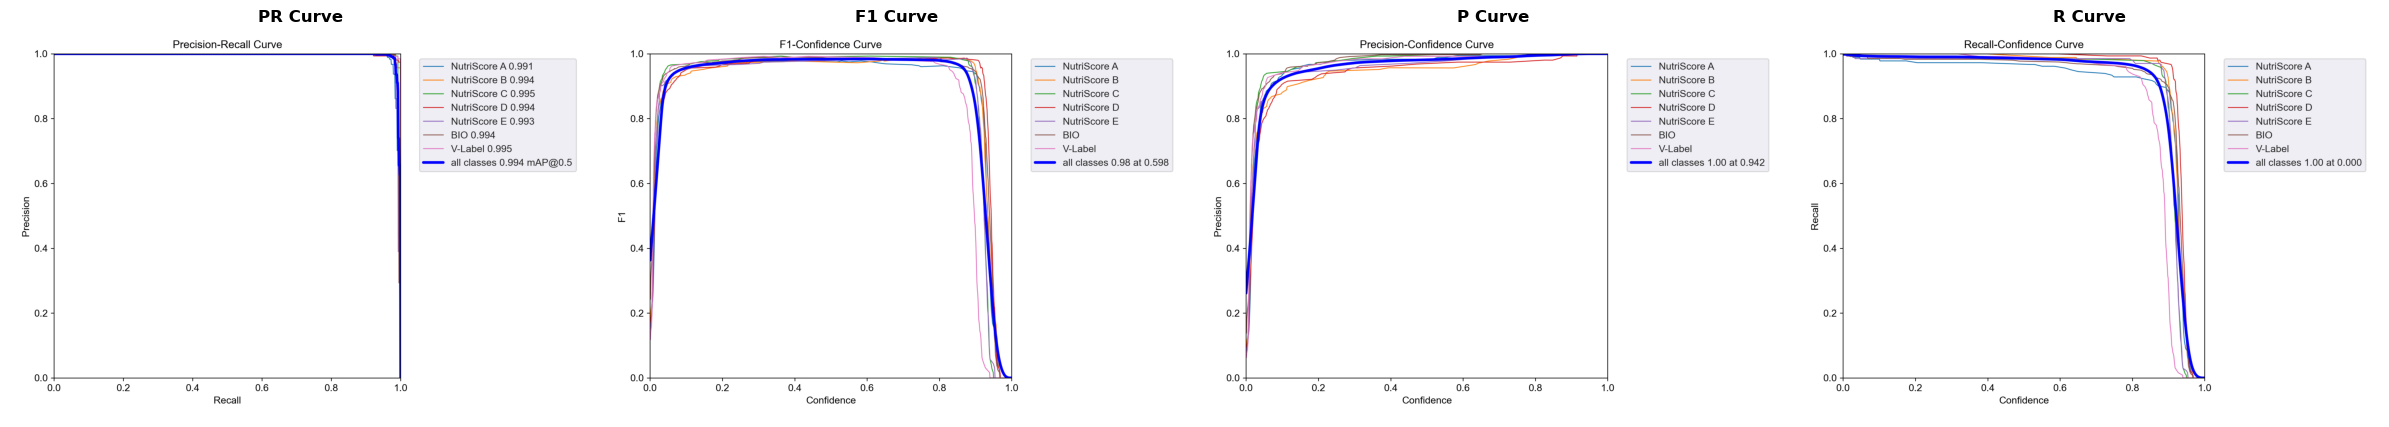


✓ Performance curves displayed

GENERATING DETECTION EXAMPLES
Running detection on 20 test images...
⚠ Detection had some issues but continuing...


In [13]:

# ============================================================================
# 5. DISPLAY PR AND F1 CURVES
# ============================================================================
print("\n" + "=" * 80)
print("PERFORMANCE CURVES")
print("=" * 80)

pr_path = VAL_DIR / 'PR_curve.png'
f1_path = VAL_DIR / 'F1_curve.png'
p_curve = VAL_DIR / 'P_curve.png'
r_curve = VAL_DIR / 'R_curve.png'

curves_found = []
for curve_path, name in [(pr_path, 'PR Curve'), (f1_path, 'F1 Curve'), 
                         (p_curve, 'P Curve'), (r_curve, 'R Curve')]:
    if curve_path.exists():
        curves_found.append((curve_path, name))
        print(f"✓ {name}: {curve_path.name}")

if curves_found:
    n_curves = len(curves_found)
    fig, axes = plt.subplots(1, n_curves, figsize=(6*n_curves, 5))
    
    if n_curves == 1:
        axes = [axes]
    
    for idx, (curve_path, name) in enumerate(curves_found):
        try:
            img = Image.open(curve_path)
            axes[idx].imshow(img)
            axes[idx].axis('off')
            axes[idx].set_title(name, fontsize=12, fontweight='bold')
        except Exception as e:
            print(f"⚠ Could not load {name}: {e}")
    
    plt.tight_layout()
    plt.savefig(VAL_DIR / 'all_curves.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\n✓ Performance curves displayed")
else:
    print("⚠ No performance curves found")

# ============================================================================
# 7. RUN DETECTION ON SAMPLE TEST IMAGES
# ============================================================================
print("\n" + "=" * 80)
print("GENERATING DETECTION EXAMPLES")
print("=" * 80)

# Get some test images
test_images = list((YOLO_DIR / 'test' / 'images').glob('*.jpg'))[:20]  # First 20 images

if test_images:
    print(f"Running detection on {len(test_images)} test images...")
    
    # Create temp directory with sample images
    temp_dir = VAL_DIR / 'sample_images'
    temp_dir.mkdir(exist_ok=True)
    
    for img in test_images:
        import shutil
        shutil.copy2(img, temp_dir / img.name)
    
    detect_cmd = [
        sys.executable,
        'detect.py',
        '--weights', str(WEIGHTS_PATH),
        '--source', str(temp_dir),
        '--img', '640',
        '--conf', '0.25',
        '--device', device,
        '--project', str(RUNS_DIR),
        '--name', 'nutrigreen_detections',
        '--exist-ok',
        '--save-txt',
        '--save-conf',
        '--line-thickness', '3',
        '--hide-labels', 'False',
        '--hide-conf', 'False'
    ]
    
    try:
        subprocess.run(detect_cmd, cwd=YOLO_REPO, check=True, 
                      capture_output=True)
        print("✓ Detection completed")
        
        DETECT_DIR = RUNS_DIR / 'nutrigreen_detections'
        print(f"✓ Detection results saved to: {DETECT_DIR}")
        
        # Display sample detections
        pred_images = list(DETECT_DIR.glob('*.jpg'))[:12]
        
        if pred_images:
            n_imgs = len(pred_images)
            cols = 4
            rows = (n_imgs + cols - 1) // cols
            
            fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))
            axes = axes.flatten() if n_imgs > 1 else [axes]
            
            for idx, img_path in enumerate(pred_images):
                try:
                    img = Image.open(img_path)
                    axes[idx].imshow(img)
                    axes[idx].axis('off')
                    axes[idx].set_title(img_path.stem, fontsize=8)
                except Exception as e:
                    print(f"⚠ Could not display {img_path.name}: {e}")
            
            # Hide unused subplots
            for idx in range(len(pred_images), len(axes)):
                axes[idx].axis('off')
            
            plt.tight_layout()
            plt.savefig(DETECT_DIR / 'sample_predictions_grid.png', dpi=200, bbox_inches='tight')
            plt.show()
            print("\n✓ Sample predictions displayed")
        
    except subprocess.CalledProcessError as e:
        print(f"⚠ Detection had some issues but continuing...")
else:
    print("⚠ No test images found")

In [14]:

# ============================================================================
# 8. MISCLASSIFICATION ANALYSIS
# ============================================================================
print("\n" + "=" * 80)
print("MISCLASSIFICATION ANALYSIS")
print("=" * 80)

print("\nAnalyzing misclassified and missed detections...")

# Create directory for misclassification analysis
misclass_dir = VAL_DIR / 'misclassifications'
misclass_dir.mkdir(exist_ok=True)

# Get test image predictions
test_labels_dir = YOLO_DIR / 'test' / 'labels'
test_images_dir = YOLO_DIR / 'test' / 'images'
detect_labels_dir = RUNS_DIR / 'nutrigreen_detections' / 'labels'

if not detect_labels_dir.exists():
    print("⚠ Detection labels not found. Running detection first...")
    # Detection was already run earlier, so labels should exist
    detect_labels_dir = VAL_DIR / 'labels'

# Analyze each test image
misclassifications = []
false_positives = []
false_negatives = []
correct_detections = []

print("\nAnalyzing test predictions...")

test_image_files = list(test_images_dir.glob('*.jpg'))
analyzed_count = 0

for img_path in test_image_files[:100]:  # Analyze first 100 images
    img_name = img_path.stem
    
    # Load ground truth
    gt_label_path = test_labels_dir / f"{img_name}.txt"
    if not gt_label_path.exists():
        continue
    
    # Load predictions
    pred_label_path = detect_labels_dir / f"{img_name}.txt"
    
    # Read ground truth
    gt_boxes = []
    with open(gt_label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 5:
                class_id = int(parts[0])
                gt_boxes.append({
                    'class': class_id,
                    'bbox': [float(x) for x in parts[1:5]]
                })
    
    # Read predictions
    pred_boxes = []
    if pred_label_path.exists():
        with open(pred_label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 6:
                    class_id = int(parts[0])
                    conf = float(parts[5])
                    pred_boxes.append({
                        'class': class_id,
                        'conf': conf,
                        'bbox': [float(x) for x in parts[1:5]]
                    })
    
    # Calculate IoU between boxes
    def calc_iou(box1, box2):
        """Calculate IoU between two boxes in YOLO format (x_center, y_center, width, height)"""
        x1_min = box1[0] - box1[2]/2
        y1_min = box1[1] - box1[3]/2
        x1_max = box1[0] + box1[2]/2
        y1_max = box1[1] + box1[3]/2
        
        x2_min = box2[0] - box2[2]/2
        y2_min = box2[1] - box2[3]/2
        x2_max = box2[0] + box2[2]/2
        y2_max = box2[1] + box2[3]/2
        
        # Calculate intersection
        inter_x_min = max(x1_min, x2_min)
        inter_y_min = max(y1_min, y2_min)
        inter_x_max = min(x1_max, x2_max)
        inter_y_max = min(y1_max, y2_max)
        
        if inter_x_max < inter_x_min or inter_y_max < inter_y_min:
            return 0.0
        
        inter_area = (inter_x_max - inter_x_min) * (inter_y_max - inter_y_min)
        box1_area = box1[2] * box1[3]
        box2_area = box2[2] * box2[3]
        union_area = box1_area + box2_area - inter_area
        
        return inter_area / union_area if union_area > 0 else 0
    
    # Match predictions to ground truth
    matched_gt = set()
    matched_pred = set()
    
    for i, gt_box in enumerate(gt_boxes):
        best_iou = 0
        best_pred_idx = -1
        
        for j, pred_box in enumerate(pred_boxes):
            if j in matched_pred:
                continue
            iou = calc_iou(gt_box['bbox'], pred_box['bbox'])
            if iou > best_iou:
                best_iou = iou
                best_pred_idx = j
        
        if best_iou > 0.5:  # IoU threshold
            matched_gt.add(i)
            matched_pred.add(best_pred_idx)
            
            pred_class = pred_boxes[best_pred_idx]['class']
            gt_class = gt_box['class']
            
            if pred_class == gt_class:
                correct_detections.append({
                    'image': img_name,
                    'gt_class': gt_class,
                    'pred_class': pred_class,
                    'conf': pred_boxes[best_pred_idx]['conf'],
                    'iou': best_iou
                })
            else:
                # Misclassification
                misclassifications.append({
                    'image': img_name,
                    'gt_class': gt_class,
                    'pred_class': pred_class,
                    'conf': pred_boxes[best_pred_idx]['conf'],
                    'iou': best_iou,
                    'image_path': img_path
                })
    
    # False negatives (missed detections)
    for i, gt_box in enumerate(gt_boxes):
        if i not in matched_gt:
            false_negatives.append({
                'image': img_name,
                'gt_class': gt_box['class'],
                'image_path': img_path
            })
    
    # False positives (incorrect detections)
    for j, pred_box in enumerate(pred_boxes):
        if j not in matched_pred:
            false_positives.append({
                'image': img_name,
                'pred_class': pred_box['class'],
                'conf': pred_box['conf'],
                'image_path': img_path
            })
    
    analyzed_count += 1

print(f"\n✓ Analyzed {analyzed_count} test images")
print(f"\nResults:")
print(f"  Correct detections: {len(correct_detections)}")
print(f"  Misclassifications: {len(misclassifications)}")
print(f"  False negatives (missed): {len(false_negatives)}")
print(f"  False positives (wrong): {len(false_positives)}")


MISCLASSIFICATION ANALYSIS

Analyzing misclassified and missed detections...

Analyzing test predictions...

✓ Analyzed 100 test images

Results:
  Correct detections: 110
  Misclassifications: 0
  False negatives (missed): 0
  False positives (wrong): 112
